In [3]:
# -------------------------------
# Block 1: Import required libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# -------------------------------
# Block 2: Load dataset
# -------------------------------
# Update the path if your file is stored elsewhere
file_path = "candidate_scores.csv"
df = pd.read_csv(file_path)

# Show top 5 rows
df.head()

,student_id,name,email,course_id,course_name,attempt_id,attempt_timestamp,score,max_score,grade,topic_tags
0,S001,Seher Varty,seher.varty@example.com,C101,Python Basics,1,2025-09-09,56,100,C,"syntax,loops"
1,S001,Seher Varty,seher.varty@example.com,C102,Data Science,1,2025-03-01,74,100,B,"numpy,pandas"
2,S001,Seher Varty,seher.varty@example.com,C103,Machine Learning,1,2025-02-04,49,100,C,"regression,classification"
3,S001,Seher Varty,seher.varty@example.com,C104,Database Systems,1,2025-01-07,72,100,B,"sql,normalization"
4,S001,Seher Varty,seher.varty@example.com,C104,Database Systems,2,2025-06-13,67,100,B,"sql,normalization"


In [5]:
# Block 3: Explore dataset
# -------------------------------
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())

# Unique students & courses
print("\nNumber of students:", df['student_id'].nunique())
print("Number of courses:", df['course_id'].nunique())

# Grade distribution
print("\nGrade distribution:\n", df['grade'].value_counts())

# Quick stats
df.describe(include='all')

Shape of dataset: (1462, 11)

Columns: ['student_id', 'name', 'email', 'course_id', 'course_name', 'attempt_id', 'attempt_timestamp', 'score', 'max_score', 'grade', 'topic_tags']

Missing values:
 student_id           0
name                 0
email                0
course_id            0
course_name          0
attempt_id           0
attempt_timestamp    0
score                0
max_score            0
grade                0
topic_tags           0
dtype: int64

Number of students: 150
Number of courses: 5

Grade distribution:
 grade
C    434
B    365
A    359
F    304
Name: count, dtype: int64


,student_id,name,email,course_id,course_name,attempt_id,attempt_timestamp,score,max_score,grade,topic_tags
count,1462,1462,1462,1462,1462,1462.000000,1462,1462.000000,1462.0,1462,1462
unique,150,150,150,5,5,NaN,250,NaN,NaN,4,5
top,S140,Suhana Thakkar,suhana.thakkar@example.com,C103,Machine Learning,NaN,2025-02-05,NaN,NaN,C,"regression,classification"
freq,14,14,14,303,303,NaN,15,NaN,NaN,434,303
mean,NaN,NaN,NaN,NaN,NaN,1.641587,NaN,60.334473,100.0,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,0.734498,NaN,22.445667,0.0,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,6.000000,100.0,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,42.250000,100.0,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,59.000000,100.0,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,79.000000,100.0,NaN,NaN


In [6]:
# Block 4: Clean & preprocess
# -------------------------------
# Convert attempt_timestamp to datetime
df['attempt_timestamp'] = pd.to_datetime(df['attempt_timestamp'])

# Sort by student and timestamp (for proper attempt order)
df = df.sort_values(by=['student_id','course_id','attempt_timestamp'])

# Ensure scores are numeric
df['score'] = pd.to_numeric(df['score'], errors='coerce')
df['max_score'] = pd.to_numeric(df['max_score'], errors='coerce')

# Drop rows with missing critical values
df = df.dropna(subset=['score','student_id','course_id'])
df.head()

,student_id,name,email,course_id,course_name,attempt_id,attempt_timestamp,score,max_score,grade,topic_tags
0,S001,Seher Varty,seher.varty@example.com,C101,Python Basics,1,2025-09-09,56,100,C,"syntax,loops"
1,S001,Seher Varty,seher.varty@example.com,C102,Data Science,1,2025-03-01,74,100,B,"numpy,pandas"
2,S001,Seher Varty,seher.varty@example.com,C103,Machine Learning,1,2025-02-04,49,100,C,"regression,classification"
3,S001,Seher Varty,seher.varty@example.com,C104,Database Systems,1,2025-01-07,72,100,B,"sql,normalization"
5,S001,Seher Varty,seher.varty@example.com,C104,Database Systems,3,2025-04-14,74,100,B,"sql,normalization"


In [7]:
# Block 5: Feature engineering
# -------------------------------
def compute_metrics(df):
    agg = df.groupby(['student_id','course_id']).agg(
        latest_score=('score', lambda x: x.iloc[-1]),
        mean_score=('score','mean'),
        best_score=('score','max'),
        attempts=('score','count'),
        std_score=('score','std')
    ).reset_index()

    # Fill NaN std (if only one attempt)
    agg['std_score'] = agg['std_score'].fillna(0)
    
    return agg

student_metrics = compute_metrics(df)
student_metrics.head()

,student_id,course_id,latest_score,mean_score,best_score,attempts,std_score
0,S001,C101,56,56.0,56,1,0.000000
1,S001,C102,74,74.0,74,1,0.000000
2,S001,C103,49,49.0,49,1,0.000000
3,S001,C104,67,71.0,74,3,3.605551
4,S001,C105,84,82.5,84,2,2.121320


In [8]:
# Block 6: Strength/Weakness classification
# -------------------------------
def classify_performance(row):
    if row['latest_score'] >= 80:
        return "Strong"
    elif row['latest_score'] >= 50:
        return "Average"
    else:
        return "Weak"

student_metrics['performance'] = student_metrics.apply(classify_performance, axis=1)
student_metrics.head(10)

,student_id,course_id,latest_score,mean_score,best_score,attempts,std_score,performance
0,S001,C101,56,56.000000,56,1,0.000000,Average
1,S001,C102,74,74.000000,74,1,0.000000,Average
2,S001,C103,49,49.000000,49,1,0.000000,Weak
3,S001,C104,67,71.000000,74,3,3.605551,Average
4,S001,C105,84,82.500000,84,2,2.121320,Strong
5,S002,C101,44,44.000000,44,2,0.000000,Weak
6,S002,C102,47,47.000000,47,1,0.000000,Weak
7,S002,C103,85,76.666667,85,3,7.637626,Strong
8,S002,C104,37,38.500000,40,2,2.121320,Weak
9,S002,C105,85,92.333333,100,3,7.505553,Strong


In [9]:
# Block 7: Recommend To-Do courses
# -------------------------------
def recommend_courses(student_id, df, student_metrics):
    # Get weak topics for this student
    weak_courses = student_metrics[(student_metrics['student_id']==student_id) & 
                                   (student_metrics['performance']=="Weak")]
    recommendations = []
    
    for _, row in weak_courses.iterrows():
        # Find topic tags of that course
        tags = df[df['course_id']==row['course_id']]['topic_tags'].iloc[0]
        recommendations.append((row['course_id'], row['latest_score'], tags))
    
    return recommendations

# Example usage:
print(recommend_courses("S001", df, student_metrics))


[('C103', 49, 'regression,classification')]


In [10]:
print(recommend_courses("S008", df, student_metrics))

[('C103', 22, 'regression,classification'), ('C104', 42, 'sql,normalization'), ('C105', 33, 'tcp,ip,routing')]


In [11]:
print(recommend_courses("S012", df, student_metrics))

[]


In [12]:
print(recommend_courses("S014", df, student_metrics))

[('C103', 38, 'regression,classification'), ('C104', 41, 'sql,normalization')]


In [13]:
print(recommend_courses("S018", df, student_metrics))

[('C101', 30, 'syntax,loops'), ('C104', 46, 'sql,normalization')]


In [14]:
# -------------------------------
# Block: Improvement Tracking
# -------------------------------

# Compute improvement for each student per course
def compute_improvement(df):
    improvement_records = []
    grouped = df.groupby(['student_id','course_id'])
    
    for (sid, cid), group in grouped:
        group = group.sort_values('attempt_timestamp')
        first_score = group['score'].iloc[0]
        last_score = group['score'].iloc[-1]
        improvement = last_score - first_score
        improvement_pct = (improvement / group['max_score'].iloc[0]) * 100
        
        improvement_records.append({
            'student_id': sid,
            'course_id': cid,
            'course_name': group['course_name'].iloc[0],
            'first_score': first_score,
            'last_score': last_score,
            'improvement': improvement,
            'improvement_pct': improvement_pct
        })
    
    return pd.DataFrame(improvement_records)

improvement_df = compute_improvement(df)
improvement_df.head()


,student_id,course_id,course_name,first_score,last_score,improvement,improvement_pct
0,S001,C101,Python Basics,56,56,0,0.0
1,S001,C102,Data Science,74,74,0,0.0
2,S001,C103,Machine Learning,49,49,0,0.0
3,S001,C104,Database Systems,72,67,-5,-5.0
4,S001,C105,Computer Networks,81,84,3,3.0


In [59]:
# -------------------------------
# Block: Pairing Algorithm (Weak ↔ Strong)
# -------------------------------

def pair_students(df, student_metrics, output_file="pairings.csv"):
    pairings = []
    
    # Loop through courses
    for course_id in df['course_id'].unique():
        course_data = student_metrics[student_metrics['course_id'] == course_id]
        
        # Separate weak & strong
        weak_students = course_data[course_data['performance'] == "Weak"]
        strong_students = course_data[course_data['performance'] == "Strong"]
        
        # Sort strong students by latest_score (descending)
        strong_students = strong_students.sort_values(by='latest_score', ascending=False)
        
        for _, weak in weak_students.iterrows():
            weak_id = weak['student_id']
            weak_name = df[df['student_id']==weak_id]['name'].iloc[0]
            
            # Pick top 2 mentors (or fewer if not available)
            mentors = strong_students.head(2)
            for _, mentor in mentors.iterrows():
                mentor_id = mentor['student_id']
                mentor_name = df[df['student_id']==mentor_id]['name'].iloc[0]
                
                pairings.append([course_id, weak_id, weak_name, mentor_id, mentor_name])
    
    # Save to CSV
    pairing_df = pd.DataFrame(pairings, columns=['course_id','weak_student_id','weak_student_name','mentor_id','mentor_name'])
    pairing_df.to_csv(output_file, index=False)
    print(f"✅ Pairings saved to {output_file}")
    return pairing_df

# Example usage
pairing_results = pair_students(df, student_metrics)
pairing_results.head(10)


✅ Pairings saved to pairings.csv


,course_id,weak_student_id,weak_student_name,mentor_id,mentor_name
0,C101,S002,Riya Rana,S008,Dharmajan Gokhale
1,C101,S002,Riya Rana,S077,Fateh Rama
2,C101,S003,Shaan Karnik,S008,Dharmajan Gokhale
3,C101,S003,Shaan Karnik,S077,Fateh Rama
4,C101,S005,Jivin Gokhale,S008,Dharmajan Gokhale
5,C101,S005,Jivin Gokhale,S077,Fateh Rama
6,C101,S018,Aarna Baral,S008,Dharmajan Gokhale
7,C101,S018,Aarna Baral,S077,Fateh Rama
8,C101,S019,Myra Sura,S008,Dharmajan Gokhale
9,C101,S019,Myra Sura,S077,Fateh Rama


C:\Users\kanth\AppData\Local\Temp\ipykernel_26304\781709913.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='performance', data=student_metrics, palette='viridis')


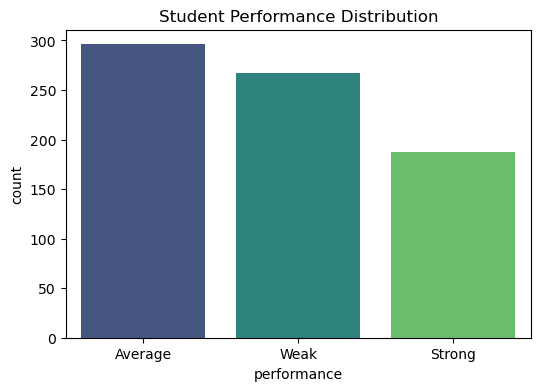

C:\Users\kanth\AppData\Local\Temp\ipykernel_26304\781709913.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_course.index, y=avg_course.values, palette='mako')


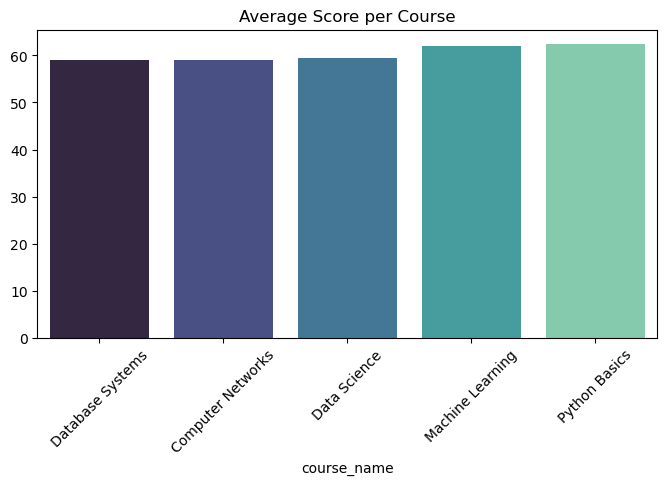

In [19]:
# -------------------------------
# Block 8: Visualization
# -------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='performance', data=student_metrics, palette='viridis')
plt.title("Student Performance Distribution")
plt.show()

# Average score per course
avg_course = df.groupby('course_name')['score'].mean().sort_values()
plt.figure(figsize=(8,4))
sns.barplot(x=avg_course.index, y=avg_course.values, palette='mako')
plt.title("Average Score per Course")
plt.xticks(rotation=45)
plt.show()


In [29]:
# -------------------------------
# Block 9: ML Classification (optional)
# -------------------------------
# Example: Predict Strong/Average/Weak using basic features
X = student_metrics[['mean_score','best_score','attempts','std_score']]
y = student_metrics['performance']

# Encode target
y = y.replace({"Weak":0, "Average":1, "Strong":2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = np.round(model.predict(X_test))

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.93      0.84      0.89        51
         1.0       0.82      0.89      0.85        63
         2.0       0.89      0.86      0.87        36

    accuracy                           0.87       150
   macro avg       0.66      0.65      0.65       150
weighted avg       0.88      0.87      0.87       150



C:\Users\kanth\AppData\Local\Temp\ipykernel_26304\829144967.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"Weak":0, "Average":1, "Strong":2})
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anac

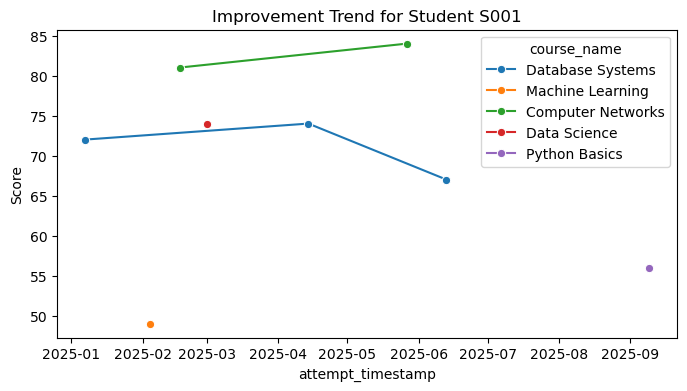

In [42]:
# Example: Plot improvement curve for a single student
def plot_student_progress(student_id, df):
    stu = df[df['student_id'] == student_id].sort_values('attempt_timestamp')
    
    plt.figure(figsize=(8,4))
    sns.lineplot(data=stu, x='attempt_timestamp', y='score', hue='course_name', marker='o')
    plt.title(f"Improvement Trend for Student {student_id}")
    plt.ylabel("Score")
    plt.show()

# Example usage
plot_student_progress("S001", df)


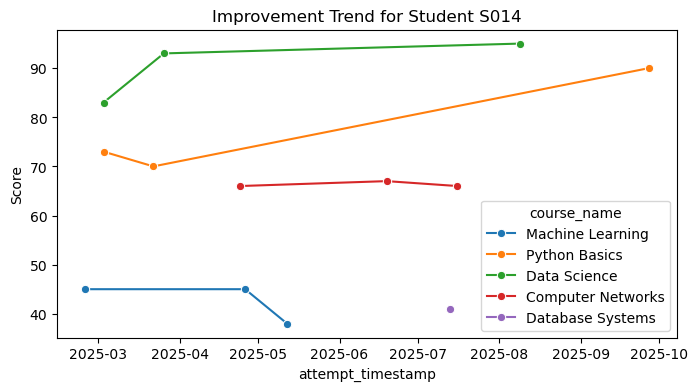

In [44]:
# Example: Plot improvement curve for a single student
def plot_student_progress(student_id, df):
    stu = df[df['student_id'] == student_id].sort_values('attempt_timestamp')
    
    plt.figure(figsize=(8,4))
    sns.lineplot(data=stu, x='attempt_timestamp', y='score', hue='course_name', marker='o')
    plt.title(f"Improvement Trend for Student {student_id}")
    plt.ylabel("Score")
    plt.show()

# Example usage
plot_student_progress("S014", df)


In [32]:
# -------------------------------
# Block: NLP Feedback Generation
# -------------------------------

def generate_feedback(student_id, df, student_metrics):
    # Get metrics for this student
    stu = student_metrics[student_metrics['student_id'] == student_id]
    if stu.empty:
        return f"No data available for student {student_id}"
    
    feedback_list = []
    name = df[df['student_id'] == student_id]['name'].iloc[0]
    
    for _, row in stu.iterrows():
        course = row['course_id']
        course_name = df[df['course_id'] == course]['course_name'].iloc[0]
        perf = row['performance']
        latest = row['latest_score']
        best = row['best_score']
        mean = row['mean_score']
        attempts = row['attempts']
        
        # Simple feedback logic
        if perf == "Strong":
            fb = f"In *{course_name}*, you have consistently performed well (latest score {latest}). Great job!"
        elif perf == "Average":
            fb = f"In *{course_name}*, you are doing reasonably well (latest score {latest}), but there is room to improve. Consider revising weak areas."
        else:  # Weak
            tags = df[df['course_id'] == course]['topic_tags'].iloc[0]
            fb = f"In *{course_name}*, your performance needs attention (latest score {latest}). We recommend practicing more on topics: {tags}."
        
        feedback_list.append(fb)
    
    # Combine into final report
    report = f"📘 Feedback Report for {name} ({student_id}):\n\n" + "\n".join(feedback_list)
    return report

# Example usage
print(generate_feedback("S001", df, student_metrics))


📘 Feedback Report for Seher Varty (S001):

In *Python Basics*, you are doing reasonably well (latest score 56), but there is room to improve. Consider revising weak areas.
In *Data Science*, you are doing reasonably well (latest score 74), but there is room to improve. Consider revising weak areas.
In *Machine Learning*, your performance needs attention (latest score 49). We recommend practicing more on topics: regression,classification.
In *Database Systems*, you are doing reasonably well (latest score 67), but there is room to improve. Consider revising weak areas.
In *Computer Networks*, you have consistently performed well (latest score 84). Great job!


In [33]:
print(generate_feedback("S012", df, student_metrics))

📘 Feedback Report for Kiaan Roy (S012):

In *Python Basics*, you have consistently performed well (latest score 95). Great job!
In *Data Science*, you have consistently performed well (latest score 80). Great job!
In *Machine Learning*, you have consistently performed well (latest score 82). Great job!
In *Database Systems*, you are doing reasonably well (latest score 60), but there is room to improve. Consider revising weak areas.
In *Computer Networks*, you are doing reasonably well (latest score 79), but there is room to improve. Consider revising weak areas.


In [34]:
print(generate_feedback("S018", df, student_metrics))

📘 Feedback Report for Aarna Baral (S018):

In *Python Basics*, your performance needs attention (latest score 30). We recommend practicing more on topics: syntax,loops.
In *Data Science*, you are doing reasonably well (latest score 62), but there is room to improve. Consider revising weak areas.
In *Machine Learning*, you are doing reasonably well (latest score 76), but there is room to improve. Consider revising weak areas.
In *Database Systems*, your performance needs attention (latest score 46). We recommend practicing more on topics: sql,normalization.
In *Computer Networks*, you have consistently performed well (latest score 93). Great job!


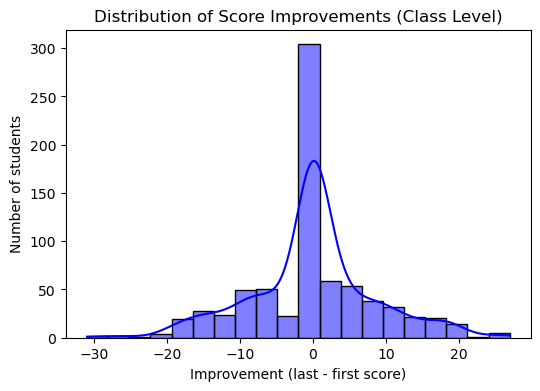

📊 Average improvement across class: -0.05 points (-0.05%)


In [46]:
# Overall improvement distribution
plt.figure(figsize=(6,4))
sns.histplot(improvement_df['improvement'], bins=20, kde=True, color='blue')
plt.title("Distribution of Score Improvements (Class Level)")
plt.xlabel("Improvement (last - first score)")
plt.ylabel("Number of students")
plt.show()

# Average improvement across class
avg_improvement = improvement_df['improvement'].mean()
avg_pct = improvement_df['improvement_pct'].mean()
print(f"📊 Average improvement across class: {avg_improvement:.2f} points ({avg_pct:.2f}%)")


In [48]:
# -------------------------------
# Enhanced Feedback with Improvement Tracking
# -------------------------------

def generate_feedback_with_improvement(student_id, df, student_metrics, improvement_df):
    # Get student name
    if student_id not in df['student_id'].values:
        return f"No data available for student {student_id}"
    
    name = df[df['student_id'] == student_id]['name'].iloc[0]
    
    # Fetch metrics & improvement for this student
    stu_metrics = student_metrics[student_metrics['student_id'] == student_id]
    stu_improvement = improvement_df[improvement_df['student_id'] == student_id]
    
    feedback_list = []
    
    for _, row in stu_metrics.iterrows():
        course = row['course_id']
        course_name = row['course_id'] + " - " + df[df['course_id'] == course]['course_name'].iloc[0]
        perf = row['performance']
        latest = row['latest_score']
        
        # Get improvement info
        imp_row = stu_improvement[stu_improvement['course_id'] == course]
        if not imp_row.empty:
            imp = imp_row['improvement'].values[0]
            imp_pct = imp_row['improvement_pct'].values[0]
            attempts = len(df[(df['student_id']==student_id) & (df['course_id']==course)])
            imp_text = f" You improved by {imp:+} marks ({imp_pct:+.1f}%) over {attempts} attempts."
        else:
            imp_text = ""
        
        # Base feedback logic
        if perf == "Strong":
            fb = f"In *{course_name}*, you have consistently performed well (latest score {latest}). Great job!{imp_text}"
        elif perf == "Average":
            fb = f"In *{course_name}*, you are doing reasonably well (latest score {latest}), but there is room to improve.{imp_text}"
        else:  # Weak
            tags = df[df['course_id'] == course]['topic_tags'].iloc[0]
            fb = f"In *{course_name}*, your performance needs attention (latest score {latest}). We recommend practicing more on topics: {tags}.{imp_text}"
        
        feedback_list.append(fb)
    
    # Final compiled report
    report = f"📘 Feedback Report for {name} ({student_id}):\n\n" + "\n".join(feedback_list)
    return report

# Example usage
print(generate_feedback_with_improvement("S001", df, student_metrics, improvement_df))


📘 Feedback Report for Seher Varty (S001):

In *C101 - Python Basics*, you are doing reasonably well (latest score 56), but there is room to improve. You improved by +0 marks (+0.0%) over 1 attempts.
In *C102 - Data Science*, you are doing reasonably well (latest score 74), but there is room to improve. You improved by +0 marks (+0.0%) over 1 attempts.
In *C103 - Machine Learning*, your performance needs attention (latest score 49). We recommend practicing more on topics: regression,classification. You improved by +0 marks (+0.0%) over 1 attempts.
In *C104 - Database Systems*, you are doing reasonably well (latest score 67), but there is room to improve. You improved by -5 marks (-5.0%) over 3 attempts.
In *C105 - Computer Networks*, you have consistently performed well (latest score 84). Great job! You improved by +3 marks (+3.0%) over 2 attempts.


In [56]:
# -------------------------------
# Block: Generate Feedback for ALL students with Download link
# -------------------------------
from IPython.display import FileLink

def generate_all_feedback(df, student_metrics, improvement_df, output_file="all_students_feedback.csv"):
    feedback_records = []
    
    for sid in df['student_id'].unique():
        feedback_text = generate_feedback_with_improvement(sid, df, student_metrics, improvement_df)
        name = df[df['student_id']==sid]['name'].iloc[0]
        feedback_records.append([sid, name, feedback_text])
    
    feedback_df = pd.DataFrame(feedback_records, columns=['student_id','name','feedback'])
    feedback_df.to_csv(output_file, index=False)
    
    print(f"✅ Feedback reports saved as {output_file}")
    return feedback_df, FileLink(output_file)

# Example usage
all_feedback, download_link = generate_all_feedback(df, student_metrics, improvement_df)

# Show preview
all_feedback.head(3)

# Show download link
download_link


✅ Feedback reports saved as all_students_feedback.csv


C:\Users\kanth\AI-Powered Candidate Performance Analyzer Folder\all_students_feedback.csv